In [1]:
import os
import ssda
import torch
import scipy
import numpy as np

from typing import List

from pathlib import Path
from dataclasses import dataclass
from matplotlib import pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

In [2]:
from ssda import data_path
raw_path = os.path.join(data_path,"raw")

# Raw Simulation

In [3]:
data_path = Path(raw_path)
mat_path = list(data_path.glob("*.mat"))[0]
mat_path

WindowsPath('D:/User/ceoj10/Codes/ssda/data/raw/Charite_CortBS_Simulations.mat')

In [4]:
mat = scipy.io.loadmat(mat_path,squeeze_me=True, struct_as_record=False)

In [5]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BSC_5', 'BSC_6', 'BSC_7', 'BSC_8', 'NDS', 'PoDmD', 'PoDmD_ks', 'PoDm_mean', 'PoDm_median', 'PoDm_peak', 'PoDm_q10', 'PoDm_q90', 'PoDm_std', 'PoDm_vec', 'PodDm_gamma_a', 'PodDm_gamma_b', 'absorption', 'att_0', 'att_5', 'att_6', 'att_7', 'att_8', 'att_f', 'f', 'po_dm_base', 'po_dm_gradient', 'pores_size', 'porosity_base', 'z'])

In [6]:
simulations_z = mat["z"]
simulations_frequencies = mat["f"]
all_images = mat["NDS"].transpose(2,0,1)
simulation_image = all_images[0]

# Raw Real

In [7]:
from ssda.data.preprocess.real import obtain_all_results
from ssda.data.preprocess.filter_images import NDS, reduce_image_frequency

In [8]:
all_result_parent_folder = "D:/Projects/Clinical_Studies/CortBS_DEGUM_2022/06_Results/"
full_data = obtain_all_results(all_result_parent_folder)

100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.81it/s]


In [9]:
mat_result = full_data["101B_Cortbs_report_no1.mat"]
real_dz = mat_result.dz
real_frequencies = mat_result.f_sampling
real_image = mat_result.Ydiff

In [10]:
dfrequencies_simulations = (simulations_frequencies[1:] - simulations_frequencies[:-1])[0]
deltaz_simulations =  (simulations_z[1:] - simulations_z[:-1])[0]

dfrequencies_real = (real_frequencies[1:] - real_frequencies[:-1])[0]
deltaz_real = (real_dz[1:] - real_dz[:-1])[0]

real_nds = NDS(max_frequency=max(real_frequencies),
               name="real",
               min_frequency=min(real_frequencies),
               number_of_frequencies=len(real_frequencies),
               delta_frequency=dfrequencies_real,
               frequencies=real_frequencies,
               z=real_dz,
               max_z=max(real_dz),
               min_z=min(real_dz),
               number_of_z=len(real_dz),
               delta_z=deltaz_real)

simulations_nds = NDS(max_frequency=max(simulations_frequencies),
                      name="simulation",
                      min_frequency=min(simulations_frequencies),
                      number_of_frequencies=len(simulations_frequencies),
                      delta_frequency=dfrequencies_simulations,
                      frequencies=simulations_frequencies,
                      z=simulations_z,
                      max_z=max(simulations_z),
                      min_z=min(simulations_z),
                      number_of_z = len(simulations_z),
                      delta_z=deltaz_simulations)

In [11]:
real_image.shape,real_nds.number_of_frequencies,real_nds.number_of_z

((513, 25), 513, 25)

In [12]:
simulation_image.shape, simulations_nds.number_of_frequencies, simulations_nds.number_of_z

((114, 35), 114, 35)

In [13]:
reduced_real_image, selected_frequencies = reduce_image_frequency(real_image,real_nds,simulations_nds.frequencies)
mat_result = full_data["101B_Cortbs_report_no1.mat"]
real_image = mat_result.Ydiff
reduced_real_images_by_frequency = {}
for name_,mat_result in full_data.items():
    reduced_real_image, _ = reduce_image_frequency(real_image,real_nds,selected_frequencies)
    reduced_real_images_by_frequency[name_] = reduced_real_image

reduced_simulations_images_by_frequency = {}
simulation_image = all_images[0]
for image_id,simulation_image in enumerate(all_images):
    reduced_simulation_image, selected_frequencies_s = reduce_image_frequency(simulation_image,simulations_nds,selected_frequencies,False)
    reduced_simulations_images_by_frequency[image_id] = reduced_simulation_image

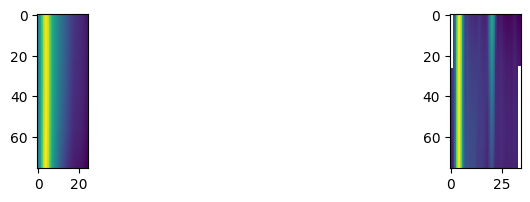

In [14]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(10,2))
axs[0].imshow(reduced_real_image)
axs[1].imshow(reduced_simulations_images_by_frequency[0])

In [15]:
# the selected z is in the real domain
selected_z = real_nds.z[4:]
selected_min_z = min(selected_z)
selected_max_z = max(selected_z)

In [16]:
final_reduced_real_image = {}
for name_,reduced_real_by_frequency in reduced_real_images_by_frequency.items():
    final_reduced_real_image[name_] = reduced_real_by_frequency[:,4:]

In [17]:
#final_reduced_real_image['101B_Cortbs_report_no1.mat']

In [18]:
real_nds.z_domain,real_nds.number_of_z

((-0.00112, 0.005599999999999999, 0.00028), 25)

In [19]:
simulations_nds.z_domain,simulations_nds.number_of_z

((-0.0009599999999999999, 0.007199999999999999, 0.00023999999999999998), 35)

In [21]:
#simulations_image

In [24]:
is_bigger  = simulations_nds.z >= selected_min_z
is_smaller = simulations_nds.z <= selected_max_z

min_z_id_simulations = min(np.where(is_bigger)[0])
max_z_id_simulations = max(np.where(is_smaller)[0])+2

filter_z_in_simulation = simulations_nds.z[min_z_id_simulations:max_z_id_simulations]

In [25]:
simulations_image = reduced_simulations_images_by_frequency[0]
filter_by_z_simulation_image = simulations_image[:,min_z_id_simulations:max_z_id_simulations]

In [28]:
interpolated_image = []
number_of_image_frequencies = filter_by_z_simulation_image.shape[0]

for frequency_id in range(number_of_image_frequencies):
    
    #frequency
    frequency_values = filter_by_z_simulation_image[frequency_id]
    interp_function = interp1d(filter_z_in_simulation, frequency_values, kind='linear', fill_value="extrapolate")

    # Use the interpolation function to find corresponding y values
    frequency_interpolated = interp_function(selected_z)
    interpolated_image.append(frequency_interpolated)
    
interpolated_image = np.vstack(interpolated_image)

In [33]:
name_,reduced_real_image = next(final_reduced_real_image.items().__iter__())

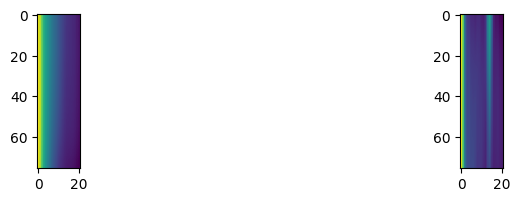

In [34]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(10,2))
axs[0].imshow(reduced_real_image)
axs[1].imshow(interpolated_image)

In [36]:
reduced_real_image.shape,interpolated_image.shape

((76, 21), (76, 21))